In [2]:
import ot
import ot.plot
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

from scipy.optimize import nnls
from scipy.spatial import cKDTree

# Helper Functions

These functions are used to generate test examples for our interpolation algorithms.

In [3]:
# Some random function to test interpolation with
def Sine(x):
    return np.sin(5*np.pi*x)

# Normalized gaussian distribution
def Gaussian(x, mean, var):
    if len(x.shape) == 1: #Convert scalars to arrays
        x = x[:, None]
    dist = np.mean((x - mean)**2, axis=1)**0.5
    exp = -0.5 * (dist / var)**2
    frac = 1 / (var * np.sqrt(2*np.pi))
    return frac * np.exp(exp)

# Get 1 Dimensional perlin noise to test our algorithms with
def getPerlinNoise1D(x, freq=[4.0, 0.0, 0.0]):
    bounds = [np.min(x), np.max(x)]
    noise = pv.perlin_noise(1, freq, 100000*np.random.random(3))
    sampled = pv.sample_function(noise, bounds=(bounds[0], bounds[1], 0, 0, 0, 0), dim=(len(x), 1, 1))
    return sampled['scalars']

# Radial Basis Interpolation

To begin with, we follow [this tutorial](https://www.youtube.com/watch?v=Kl9xk9BukNE&t=768s) as a starting point to familiarize ourselves with Radial Basis Function (RBF) interpolation. We want to interpolate target points $x_t$ based on source points $x_s$. For the purpose of testing, we will use some random function source our points $x_s$ from.

Text(0, 0.5, 'y')

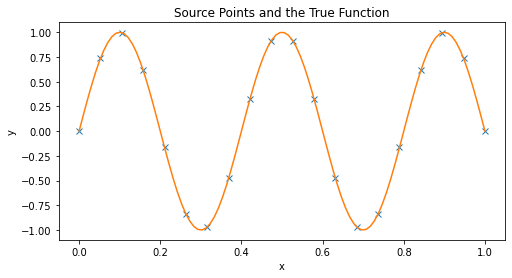

In [4]:
xs = np.linspace(0, 1, 20)
xt = np.linspace(0, 1, 100)

plt.figure(figsize=(8, 4))
plt.plot(xs, Sine(xs), 'x')
plt.plot(xt, Sine(xt))
plt.title('Source Points and the True Function')
plt.xlabel('x')
plt.ylabel('y')

## Theory

Our true data is given as points $X_s = \{x_0, ..., x_s\}$ and $Y_s = \{y_0, ..., y_s\}$ and the kernel for the Guassian RBF is given by:
$$ \phi = \frac{1}{\sigma \sqrt{2 \pi}} e^{-\frac{r^2}{2 \sigma^2}}$$

where $r = \|x_i - x_j\|$, and $\epsilon$ is some coefficient. We find weights $w_s$ by means of *np.linalg.solve()* such that:

$$
\Phi_s = 
\begin{bmatrix}
    \phi \|x_0 - x_0\| & ... & \phi \|x_s - x_0\| \\
    ... & ... & ... \\
    \phi \|x_0 - x_s\| & ... & \phi \|x_s - x_s\| 
\end{bmatrix}
w_s = y_s
$$

After knowing $w_s$ and $x_s$, we can approximate $y_t$ given points $x_t$ using:
$$
\Phi_t = 
\begin{bmatrix}
    \phi \|x_0 - x_0\| & ... & \phi \|x_s - x_0\| \\
    ... & ... & ... \\
    \phi \|x_0 - x_t\| & ... & \phi \|x_s - x_t\| 
\end{bmatrix}
w_s = y_t
$$

In other words, any point $y_i \in Y_t$ can be approximated using:
$$
y_i = \sum_{s=1}^n w_s \phi(\|x_i - x_s\|)
$$
which is the sum of Gaussian Particles with appropriate weights. Notice that if we multiply the above matrices with $\Phi w$, we get the gaussian particles evaluated at $X_t$, and so we will be refering to these matrices as "particles" in our code. Meanwhile we $\Phi$ will be refered to as RBF in our code.

To begin with, we will define the distance $r = \|x_i - x_j\|$ and the RBF function. Following the paper's implementation, we let $\sigma$ equal to n times the distance between particles.

Text(0.5, 1.0, 'Radial Basis Function')

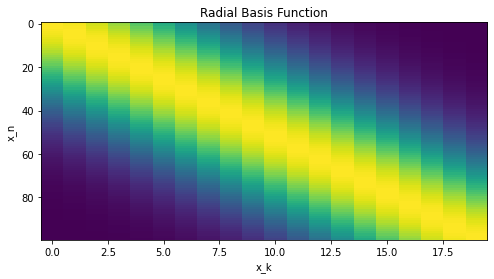

In [5]:
# Get euclidean distance of each pair of points
def getDistance(x, xk):
    difference = x.reshape(-1, 1) - xk.reshape(1, -1)
    return np.sqrt(difference**2)

# Gaussian radial basis function
def gaussRBF(radius, sigma, eps=1e8):
    if sigma.dtype != np.float64:
        sigma[sigma==0] = eps
    coeff = 1/(sigma*(2*np.pi)**0.5)
    return coeff * np.exp(-0.5*(radius / sigma)**2)

# Set standard deviation of particles
nthNeighbour = 5
std = nthNeighbour * (xs[1] - xs[0])

# Plot radial basis function
plt.figure(figsize=(8, 4))
plt.imshow(gaussRBF(getDistance(xt, xs), std), aspect='auto', interpolation='nearest')
plt.xlabel('x_k')
plt.ylabel('x_n')
plt.title('Radial Basis Function')

Using these functions, we can create an RBF interpolator by solving for $w_k$. 

Note that the tutorial I am following here uses *np.linalg.solve()* to get their mass $w$, this works great for basic RBF interpolation, but will fail for displacement interpolation in general. In this particular case, we get nice looking particles with reasonable weights assigned to each particle, but in general *np.linalg.solve()* might give particles with ridiculously large weights. In our later work, we will be using solvers that restricts $w$ to positive values only.

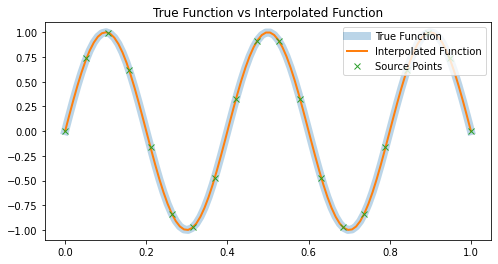

In [6]:
# RBF Interpolator calss
class RBFInterp(object):
    def __init__(self, eps):
        self.eps = eps
    
    # Solve w_k
    def fit(self, xk, yk):
        self.xk = xk
        dist = getDistance(xk, xk)
        particles = gaussRBF(dist, self.eps)
        self.w = np.linalg.solve(particles, yk)
    
    # Apply interpolation
    def __call__(self, xn):
        dist = getDistance(xn, self.xk)
        particles = gaussRBF(dist, self.eps)
        return particles.dot(self.w)

# Create and fit data to RBF Interpolator
ys = Sine(xs)
interp = RBFInterp(std)
interp.fit(xs, ys)

# Plot results
plt.figure(figsize=(8, 4))
plt.plot(xt, Sine(xt), linewidth=8, alpha=0.3)
plt.plot(xt, interp(xt), linewidth=2)
plt.plot(xs, ys, 'x')
plt.title('True Function vs Interpolated Function')
plt.legend(['True Function', 'Interpolated Function', 'Source Points'], loc='upper right')
plt.show()

# RBF as Gaussian Particles

To visualize the gaussian interpolation as particles. Each coloumn of $\Phi_t w$ will provide us with each particle evaluated at locations $x_t$.

The mean of each gaussian distribution is given by $x_k$, and the amplitude is given by $w_k$.

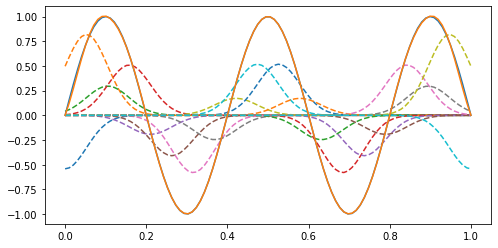

In [7]:
#eps = 20
numParticles = 20

# Get source points make particles from
xs = np.linspace(0, 1, numParticles)
ys = Sine(xs)
std = 1 * (xs[1] - xs[0])

# Solve weights w_k
dist = getDistance(xs, xs)
RBFs = gaussRBF(dist, std)
w = np.linalg.solve(RBFs, ys)

# Get RBF transormation matrix for interpolation
xt = np.linspace(0, 1, 100)
dists = getDistance(xt, xs)
RBFt = gaussRBF(dists, std)
particles = RBFt * w

# Visualize Gaussian Particles and interpolation
plt.figure(figsize=(8, 4))
for s, ws in enumerate(w):
    plt.plot(xt, particles[:, s], '--')
plt.plot(xt, Sine(xt))
plt.plot(xt, RBFt.dot(w))

# Displacement Interpolation

We now want to solve the displacement interpolation to interpolate from our source distribution F: $(x_s, y_s)$ to our target distribution G: $(x_t, y_t)$. As a toy example, we will be using two gaussians for our source and target distributions.

Note that at this stage, our interpolator will only be capable of interpolating purely positive distributions. We will change this later to also include negative distributions.

In [1]:
# Class for representing a distribution as Gaussian Particles
class GaussParticles:
    def __init__(self, x, y, nthNeighbour=5):
        
        # Set up variables
        self.x = x
        self.y = y
        self.numParts = len(x)
        self.std = nthNeighbour * (x[1] - x[0])
        
        # Compute RBF
        dist = getDistance(self.x, self.x)
        self.RBF = gaussRBF(dist, self.std)

        # Solve for W, uncomment the line bellow to see the issue with np.linalg.solve()
        self.w, _ = nnls(self.RBF, self.y)
        #self.w = np.linalg.solve(self.RBF, self.y)
        
        # Store parameters we might be interested in later
        self.particles = self.RBF * self.w
        self.wNormed = self.w / np.sum(self.w)
        self.interp = np.sum(self.particles, axis=1)
        

# Create source distribution F and create particles
numParticles = 100
xs = np.linspace(-5, 5, numParticles)
ys = Gaussian(xs, -2, 0.5)
F = GaussParticles(xs, ys)

# Create target distribution G and create particles
xt = np.linspace(-5, 5, numParticles)
yt = Gaussian(xt, 2, 2)
G = GaussParticles(xt, yt)

# Plot results
plt.figure(figsize=(8, 4))
for i in range(numParticles):
    plt.plot(F.x, F.particles[:, i], 'b', linewidth=0.5)
    plt.plot(G.x, G.particles[:, i], 'r', linewidth=0.5)
plt.plot(F.x, np.sum(F.particles, axis=1), 'b')
plt.plot(G.x, np.sum(G.particles, axis=1), 'r')
plt.title('Distributions and Particles to be Interpolated')
plt.show()

NameError: name 'np' is not defined

Given a set of gaussian particles, we want to minimize the cost of transporting those particles from distribution $f_i$ to $g_j$, in otherwords, we want:
$$
\min_x \sum_i \sum_j c_{i, j} x_{i \rightarrow j} \\
$$

such that:
$$
x_{i \rightarrow j} \geq 0 \\
\sum_i x_{i \rightarrow j} = g_j \\
\sum_j x_{i \rightarrow j} = f_i
$$

where $c_{i, j}$ is the transporation cost such as euclidean distance. The python library OT (optimal transport) solves this problem for us, so we won't need to write our own code for this.

We begin by creating a matrix of distances $D$, where the entries $d_{i, j}$ correspond to distances between particles i and j. The function *ot.emd* (Earth's Mover Distance) gives us the optimal transport matrix, which tells us how much mass to move from i to j. We then create a pairing of particles for every pair of particles that needs mass moved above a particular threshold.


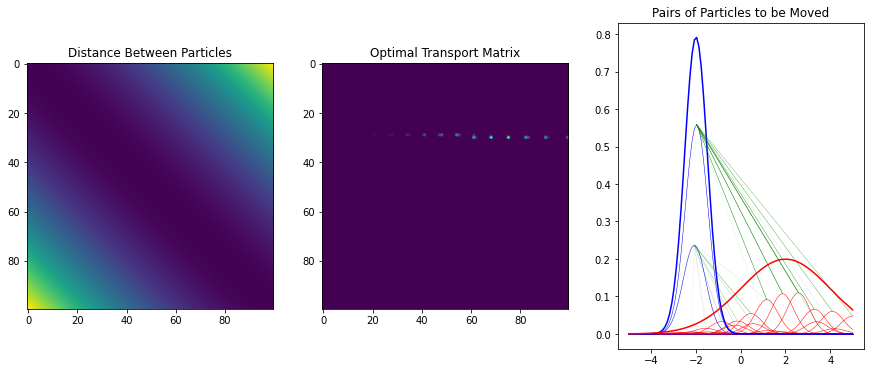

In [8]:
# Get transport matrix
D = ot.dist(F.x[:, None], G.x[:, None])
Trans = ot.emd(F.wNormed, G.wNormed, D)

# Find pairs of particles to be moved from and to using Optimal Transport Matrix
threshold = 1e-8
pairs = np.argwhere(Trans > threshold / Trans.max())

# Plot distance and OT Matrix
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
ax[0].imshow(D)
ax[1].imshow(Trans)
ax[0].set_title('Distance Between Particles')
ax[1].set_title('Optimal Transport Matrix')

# Plot Particles and their interpolation results
for i in range(numParticles):
    ax[2].plot(F.x, F.particles[:, i], 'b', linewidth=0.5)
    ax[2].plot(G.x, G.particles[:, i], 'r', linewidth=0.5)
ax[2].plot(F.x, F.interp, 'b')
ax[2].plot(G.x, G.interp, 'r')

# Plot lines representing the pairing of particles
ax[2].set_title('Pairs of Particles to be Moved')
for pair in pairs:
    x1 = F.x[pair[0]]
    y1 = np.max(F.particles[:, pair[0]])
    x2 = G.x[pair[1]]
    y2 = np.max(G.particles[:, pair[1]])
    mass = Trans[pair[0], pair[1]] * 4
    ax[2].plot([x1, x2], [y1, y2], color='g', linewidth=mass)
plt.show()

After identifying the pairs of particles to be interpolated, we use displacement interpolation to create a new distribution H. In this new distribution, each particle is created by each pair above. Let $t \in [0, 1]$ be the advection amount, the location of the new particle is:

$$ x_h = t x_g + (1 - t) x_f$$

It's mass $w_h$ contained by each particle is defined by the corresponding entry in the optimal transport matrix between particles.

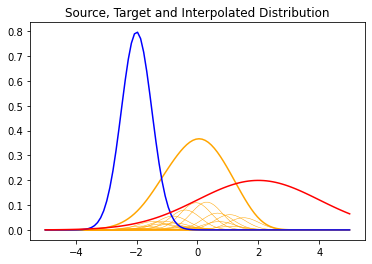

In [9]:
# Create new particles based on pairs and move them
t = 0.5
xh = t * G.x[pairs[:, 1]] + (1 - t) * F.x[pairs[:, 0]]
wh = Trans[pairs[:, 0], pairs[:, 1]]

# Sum up moved particles to get the final interpolation
distH = getDistance(xh, F.x)
RBFh = gaussRBF(distH, F.std)
totalMass = t * np.sum(G.w) + (1 - t) * np.sum(F.w)
particleH = totalMass * RBFh * wh[:, None]

# Plot results
for i in range(particleH.shape[0]):
    plt.plot(F.x, particleH[i], 'orange', linewidth=0.5)
plt.plot(F.x, np.sum(particleH, axis=0), 'orange')
plt.plot(F.x, F.y, 'b')
plt.plot(G.x, G.y, 'r')
plt.title('Source, Target and Interpolated Distribution')
plt.show()

# Distributions with Negative Values

As we can see in the code bellow, our basic RBF interpolator does not perform well on distributions with negative entries.

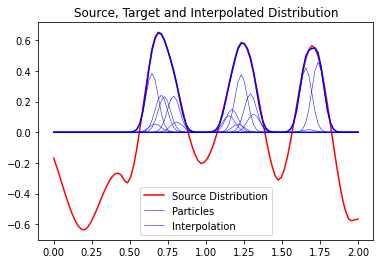

In [10]:
# Create source distribution F and create particles
numParticles = 100
xs = np.linspace(0, 2, numParticles)
ys = getPerlinNoise1D(xs)
F = GaussParticles(xs, ys, nthNeighbour=2)

# Plot results
plt.plot(F.x, F.y, 'r')
for i in range(F.particles.shape[0]):
    plt.plot(F.x, F.particles[:, i], 'b', linewidth=0.5)
plt.plot(F.x, F.interp, 'b')
plt.title('Source, Target and Interpolated Distribution')
plt.legend(['Source Distribution', 'Particles', 'Interpolation'])
plt.show()

To solve this, we will split the distribution to positive and negative distributions.

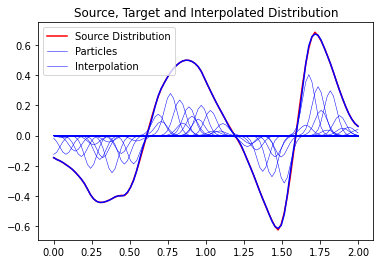

In [11]:
# Class for representing a distribution as Gaussian Particles
class GaussPartsPosNeg:
    def __init__(self, x, y, nthNeighbour=2):
        
        # Store coordinates
        self.x = x
        self.y = y
        self.yPos = y * (y > 0)
        self.yNeg = - y * (y < 0)

        # Create positive and negative particles
        self.posParts = GaussParticles(x, self.yPos, nthNeighbour=nthNeighbour)
        self.negParts = GaussParticles(x, self.yNeg, nthNeighbour=nthNeighbour)

        # Combine positive and negative components
        self.interp = self.posParts.interp - self.negParts.interp
        self.particles = np.concatenate((self.posParts.particles, -self.negParts.particles), axis=1)

# Create source distribution F and create particles
numParticles = 100
xs = np.linspace(0, 2, numParticles)
ys = getPerlinNoise1D(xs)
F = GaussPartsPosNeg(xs, ys, nthNeighbour=2)

# Plot results
plt.plot(F.x, F.y, 'r')
for i in range(F.particles.shape[1]):
    plt.plot(F.x, F.particles[:, i], 'b', linewidth=0.5)
plt.plot(F.x, F.interp, 'b')
plt.title('Source, Target and Interpolated Distribution')
plt.legend(['Source Distribution', 'Particles', 'Interpolation'])
plt.show()

## Classes for Displacement Interpolation

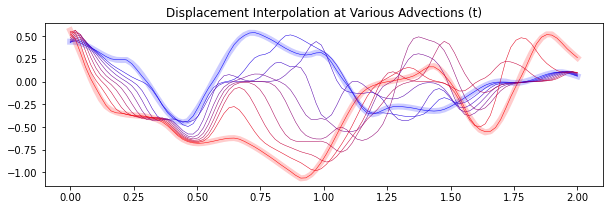

In [12]:
# Displacement interpolator for positive distributions only
class DispInterpPositives:
    def __init__(self, F, G, threshold=1e-8):

        # Source and target distributions (as particles objects)
        self.F = F
        self.G = G
        
        # Get transport matrix
        D = ot.dist(F.x[:, None], G.x[:, None])
        self.Trans = ot.emd(F.wNormed, G.wNormed, D)

        # Find pairs of particles to be moved from and to using Optimal Transport Matrix
        self.pairs = np.argwhere(self.Trans > threshold /self.Trans.max())
    
    # Move particles somewhere between distributions F and G
    def advectParticles(self, t):
        xh = t * self.G.x[self.pairs[:, 1]] + (1 - t) * self.F.x[self.pairs[:, 0]]
        wh = self.Trans[self.pairs[:, 0], self.pairs[:, 1]]

        # Sum up moved particles to get the final interpolation
        distH = getDistance(xh, self.F.x)
        RBFh = gaussRBF(distH, self.F.std)
        totalMass = t * np.sum(self.G.w) + (1 - t) * np.sum(self.F.w)
        
        # Final interpolation and their particles
        self.particles = totalMass * RBFh * wh[:, None]
        self.interp = np.sum(self.particles, axis=0)

# Displacement interpolator for distributions with positive and negative components
class DispInterp:
    def __init__(self, F, G, threshold=1e-8):

        # Create interpolator for positive and negative components
        self.F = F
        self.G = G
        self.posInterp = DispInterpPositives(F.posParts, G.posParts, threshold=threshold)
        self.negInterp = DispInterpPositives(F.negParts, G.negParts, threshold=threshold)

    # Move particles somewhere between each distribution
    def advectParticles(self, t):
        self.posInterp.advectParticles(t)
        self.negInterp.advectParticles(t)

        # Combine positive and negative components
        self.interp = self.posInterp.interp - self.negInterp.interp
        self.particles = np.concatenate((self.posInterp.particles, -self.negInterp.particles), axis=0)

# Create source distribution F and create particles
numParticles = 100
xs = np.linspace(0, 2, numParticles)
ys = getPerlinNoise1D(xs)
F = GaussPartsPosNeg(xs, ys, nthNeighbour=2)

# Create target distribution G and create particles
xt = np.linspace(0, 2, numParticles)
yt = getPerlinNoise1D(xt)
G = GaussPartsPosNeg(xt, yt, nthNeighbour=2)

# Create interpolator and advect particles
H = DispInterp(F, G)

# Plot results
plt.figure(figsize=(10, 3))
for t in np.linspace(0, 1, 10):
    H.advectParticles(t)
    plt.plot(F.x, H.interp, linewidth=0.5, color=(t, 0.0, (1 - t)))
plt.plot(F.x, F.y, 'b', alpha=0.2, linewidth=6)
plt.plot(G.x, G.y, 'r', alpha=0.2, linewidth=6)
plt.title('Displacement Interpolation at Various Advections (t)')
plt.show()

# Memory Concerns

It seems that the number of particles that we can have is limited by our memory. The paper I'm following says they can simulate about 32,000 particles. Using scipy's built in RBF interpolator, we can only use about 20,000 nodes, which is about the same amount of nodes that an icosphere with 6 subdivisions has.


In [15]:
from scipy.interpolate import Rbf

if False:
    numParticles = 20000
    x = np.linspace(0, 2, numParticles).astype(np.float32)
    y = getPerlinNoise1D(x).astype(np.float32)
    rbf = Rbf(x, y, function='gaussian')

# Using Gaussian Particles for Plate Tectonics

In our previous works, we simulated tectonic plate movement based on points on a spherical mesh. I think we can get better results by representing the simulation as gaussian particles, and then using ideas from particle dynamics to simulate tectonic plates. For demonstrational purposes, I provide some very simple examples here.

To begin with, we initiate a flat landscape using evenly distributed particles, each with constant size (standard deviation) and mass $w$.

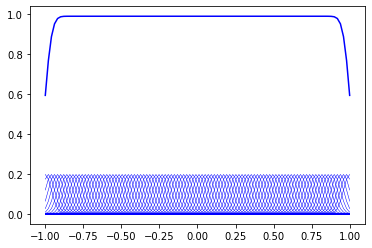

In [71]:
# We begin with a flat landscape
numParticles = 100
x = np.linspace(-1, 1, numParticles)

# We manualy set the mass of each particle to a constant (instead of calculating it based on a given landscape)
w = 0.02

# Create evenly distributed Gaussian particles
std = 2 * (x[1] - x[0])
dist = getDistance(x, x)
RBF = gaussRBF(dist, std)
particles = w * RBF
heightMap = np.sum(particles, axis=1)

# Plot the initial landscape
plt.plot(x, heightMap, 'b')
for i in range(numParticles):
    plt.plot(x, particles[:, i], 'b', linewidth=0.5)
plt.show()

# Diverging Tectonic Plates

To test how gaussian particles could be used to replicate diverging tectonic plates, we simply move each particle away from each other. Note that we can improve this simulation by adding a repulsive force, so that particles try to move away from each other, thus filling in the empty space between diverging plates. In addition, we could "spawn" new particles at diverging boundaries to replicate volcanic activity.

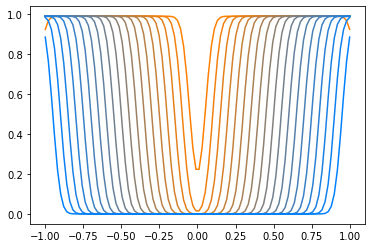

In [73]:
dt = 0.05
finalTime = 1
numParticles = 100
x = np.linspace(-1, 1, numParticles)
w = 0.02 * np.ones(numParticles)
newX = np.copy(x)

# Loop through iterations of tectonic simulation
for t in np.linspace(0, finalTime, int(finalTime//dt)):

    # Update location of particles
    newX = newX + np.sign(newX) * dt

    # Get resulting heightmap
    dist = getDistance(x, newX)
    RBF = gaussRBF(dist, std)
    particles = w * RBF
    heightMap = np.sum(particles, axis=1)

    # Plot current heightmap
    c = t / finalTime
    plt.plot(x, heightMap, color=[(1 - c), 0.5, c])
plt.show()

# Converging Tectonic Plates

To simulate converging tectonic plates, we simply move particles towards each other. Once again, by adding a repulsive force between each particle, we can limit the height that mountains will grow towards, and create plateaus instead. To represent submerging plates, we can simply remove particles from submerging boundaries.

To ensure that mass is always conserved, we can make sure that the number of particles deleted at submerging boundaries equals the number of particles spawned due to volcanic activity.

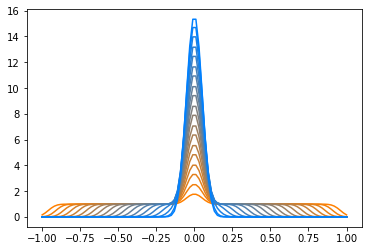

In [74]:
dt = 0.05
finalTime = 1
numParticles = 100
x = np.linspace(-1, 1, numParticles)
w = 0.02 * np.ones(numParticles)
newX = np.copy(x)

# Loop through iterations of tectonic simulation
for t in np.linspace(0, finalTime, int(finalTime//dt)):

    # Update location of particles
    newX = newX - np.sign(newX) * dt

    # Get resulting heightmap
    dist = getDistance(x, newX)
    RBF = gaussRBF(dist, std)
    particles = w * RBF
    heightMap = np.sum(particles, axis=1)

    # Plot current heightmap
    c = t / finalTime
    plt.plot(x, heightMap, color=[(1 - c), 0.5, c])
plt.show()

# Randomly Distributed Particles

The smoothness of the terrain depends on the standard deviation $\sigma$ of particles. In addition, too few particles with small $\sigma$ results in "Gaps" between our particles. Thus we must make sure our $\sigma$ is sufficiently large based on how many particles we have.

In my discussion with tristan, this simulation would be used to specify the tectonic uplift map for GOSPL simulation. As such, we don't care if our terrain is "too smooth". We may be limited to around 20,000 particles, but that is plenty to create a good enough estimate of earth's tectonic uplift.

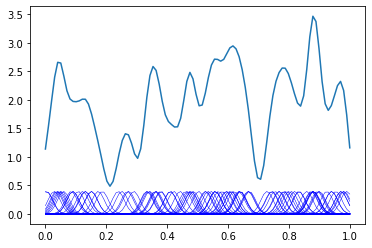

In [103]:
# The standard deviation controls the "smoothness" of our terrain
std = 2 * (x[1] - x[0])

# Other parameters
numParticles = 100
x = np.linspace(0, 1, numParticles)
particleLocation = np.random.random(numParticles)
w = 0.02 * np.ones(numParticles)

# Get resulting heightmap
dist = getDistance(x, particleLocation)
RBF = gaussRBF(dist, std)
particles = w * RBF
heightMap = np.sum(particles, axis=1)

# Plot results
plt.plot(x, heightMap)
for i in range(numParticles):
    plt.plot(x, particles[:, i], 'b', linewidth=0.5)
plt.show()